# CartPole - Reinforcement Learning
### Aldo Serrano Rugerio 165241


## Importing libraries

In [3]:
import tensorflow as tf
import numpy as np
import gymnasium as gym

In [4]:
# Libraries for visualization and handling the plots
import matplotlib.animation
import matplotlib.pyplot as plt
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
plt.rc('animation', html='jshtml')

## Function to save the graphs inside a folder

In [5]:
from pathlib import Path

IMAGES_PATH = Path() / "imagesCartPole" / "rl"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## Creating the environment with the library gym, and reseting the environment

In [6]:
env = gym.make("CartPole-v1", render_mode="rgb_array")
obs, info = env.reset(seed=42)

## Function to plot the environment

In [7]:
def plot_environment(env, figsize=(5, 4)):
    plt.figure(figsize=figsize)
    img = env.render()
    plt.imshow(img)
    plt.axis("off")
    return img

## Plotting the environment

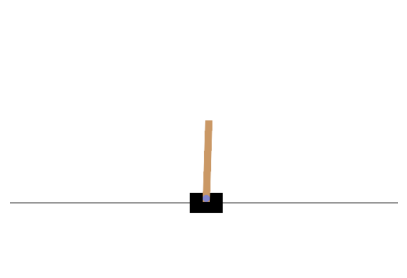

<Figure size 640x480 with 0 Axes>

In [8]:
plot_environment(env)
plt.show()
save_fig("cart_pole_plot")

## Setting up an initial action for the environment just to test the environment

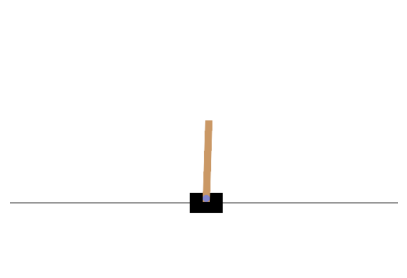

In [9]:
action = 0 # accelerate left
obs, reward, done, truncated, info = env.step(action)
# Plotting the environment after the action
plot_environment(env)
plt.show()
# Resetting the environment
obs, info = env.reset()

## Simple hard-coded policy to test the environment

In [10]:
def hard_coded_policy(obs):
    angle = obs[2]
    return 0 if angle < 0 else 1

totals = []
for episode in range(500):
    episode_rewards = 0
    obs, info = env.reset()
    for step in range(200):
        action = hard_coded_policy(obs)
        obs, reward, done, truncated, info = env.step(action)
        episode_rewards += reward
        if done:
            break
    totals.append(episode_rewards)
    
# Printing the results
np.mean(totals), np.std(totals), np.min(totals), np.max(totals)

(42.19, 9.011875498474222, 24.0, 72.0)

### Visualization of the environment with the hard-coded policy in one episode

In [11]:
def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    anim = matplotlib.animation.FuncAnimation(
        fig, update_scene, fargs=(frames, patch),
        frames=len(frames), repeat=repeat, interval=interval)
    plt.close()
    return anim

def show_one_episode(policy, n_max_steps=200, seed=42):
    frames = []
    env = gym.make("CartPole-v1", render_mode="rgb_array")
    np.random.seed(seed)
    obs, info = env.reset(seed=seed)
    for step in range(n_max_steps):
        frames.append(env.render())
        action = policy(obs)
        obs, reward, done, truncated, info = env.step(action)
        if done or truncated:
            break
    env.close()
    return plot_animation(frames)

show_one_episode(hard_coded_policy)

# Neural Network Policy

In [12]:
tf.random.set_seed(42)

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(5, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid"),
])

## Function that uses the neural network to predict the action of moving left or right

In [13]:
def nn_policy(obs):
    left_proba = model.predict(obs[np.newaxis], verbose=0)[0][0]
    return int(np.random.rand() > left_proba)

np.random.seed(42)
show_one_episode(nn_policy)

# Policy Gradients

## Function to play a single step in the environment

In [14]:
def play_one_step(env, obs, model, loss_fn):
    with tf.GradientTape() as tape:
        left_proba = model(obs[np.newaxis])
        action = (tf.random.uniform([1, 1]) > left_proba)
        y_target = tf.constant([[1.]]) - tf.cast(action, tf.float32)
        loss = tf.reduce_mean(loss_fn(y_target, left_proba))

    grads = tape.gradient(loss, model.trainable_variables)
    obs, reward, done, truncated, info = env.step(int(action))
    return obs, reward, done, truncated, grads

## Function to play multiple episodes

In [15]:
def play_multiple_episodes(env, n_episodes, n_max_steps, model, loss_fn):
    all_rewards = []
    all_grads = []
    for episode in range(n_episodes):
        current_rewards = []
        current_grads = []
        obs, info = env.reset()
        for step in range(n_max_steps):
            obs, reward, done, truncated, grads = play_one_step(
                env, obs, model, loss_fn)
            current_rewards.append(reward)
            current_grads.append(grads)
            if done or truncated:
                break

        all_rewards.append(current_rewards)
        all_grads.append(current_grads)

    return all_rewards, all_grads

## Function to discount the rewards, and normalize them

In [16]:
def discount_rewards(rewards, discount_factor):
    discounted = np.array(rewards)
    for step in range(len(rewards) - 2, -1, -1):
        discounted[step] += discounted[step + 1] * discount_factor
    return discounted

def discount_and_normalize_rewards(all_rewards, discount_factor):
    all_discounted_rewards = [discount_rewards(rewards, discount_factor)
                              for rewards in all_rewards]
    flat_rewards = np.concatenate(all_discounted_rewards)
    reward_mean = flat_rewards.mean()
    reward_std = flat_rewards.std()
    return [(discounted_rewards - reward_mean) / reward_std
            for discounted_rewards in all_discounted_rewards]

## Create the model, reset the environment, and play multiple episodes

In [17]:
# Setting the parameters
n_iterations = 150
n_episodes_per_update = 10
n_max_steps = 200
discount_factor = 0.95

# Creating the model
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(5, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid"),
])

# Resetting the environment
obs, info = env.reset()

# Optimizer and loss function
optimizer = tf.keras.optimizers.Nadam(learning_rate=0.01)
loss_fn = tf.keras.losses.binary_crossentropy

# Playing multiple episodes
for iteration in range(n_iterations):
    all_rewards, all_grads = play_multiple_episodes(
        env, n_episodes_per_update, n_max_steps, model, loss_fn)

    # Debugging information printed in the console
    total_rewards = sum(map(sum, all_rewards))
    print(f"\rIteration: {iteration + 1} of {n_iterations}," f" Mean Rewards: {total_rewards / n_episodes_per_update:.1f}", end="")
    # Print if the iterations are already finished
    if iteration > 50:
        print(" Be patient", end="")
    elif iteration > 120:
        print(" Almost done, hang tight!", end="")
    elif iteration == n_iterations:
        print(" Done! :D", end="")
    else:
        print(" Calculating...", end="")

    all_final_rewards = discount_and_normalize_rewards(all_rewards,
                                                       discount_factor)
    all_mean_grads = []
    for var_index in range(len(model.trainable_variables)):
        mean_grads = tf.reduce_mean(
            [final_reward * all_grads[episode_index][step][var_index]
             for episode_index, final_rewards in enumerate(all_final_rewards)
                 for step, final_reward in enumerate(final_rewards)], axis=0)
        all_mean_grads.append(mean_grads)

    optimizer.apply_gradients(zip(all_mean_grads, model.trainable_variables))
    
# Display the animation
np.random.seed(42)
show_one_episode(nn_policy)

Iteration: 150 of 150, Mean Rewards: 173.8 Be patient..

# Q Value Iteration

## Defining the transition probabilities, rewards, and possible actions

In [18]:
transition_probabilities = [  # shape=[s, a, s']
    [[0.7, 0.3, 0.0], [1.0, 0.0, 0.0], [0.8, 0.2, 0.0]],
    [[0.0, 1.0, 0.0], None, [0.0, 0.0, 1.0]],
    [None, [0.8, 0.1, 0.1], None]
]
rewards = [  # shape=[s, a, s']
    [[+10, 0, 0], [0, 0, 0], [0, 0, 0]],
    [[0, 0, 0], [0, 0, 0], [0, 0, -50]],
    [[0, 0, 0], [+40, 0, 0], [0, 0, 0]]
]
possible_actions = [[0, 1, 2], [0, 2], [1]]

# -np.inf for impossible actions
Q_values = np.full((3, 3), -np.inf)  
for state, actions in enumerate(possible_actions):
    # for all possible actions
    Q_values[state, actions] = 0.0  
    
# Discount factor
gamma = 0.90  

history1 = []  
for iteration in range(50):
    Q_prev = Q_values.copy()
    history1.append(Q_prev)
    for s in range(3):
        for a in possible_actions[s]:
            Q_values[s, a] = np.sum([
                    transition_probabilities[s][a][sp]
                    * (rewards[s][a][sp] + gamma * Q_prev[sp].max())
                for sp in range(3)])

history1 = np.array(history1)

# Print the Q_values
for i in range(3):
    print(f"State {i} - Q_values: {Q_values[i]}") 
# Optimal actions for each state
for i in range(3):
    print(f"State {i} - Optimal action: {np.argmax(Q_values[i])}")

State 0 - Q_values: [18.91891892 17.02702702 13.62162162]
State 1 - Q_values: [ 0.                -inf -4.87971488]
State 2 - Q_values: [       -inf 50.13365013        -inf]
State 0 - Optimal action: 0
State 1 - Optimal action: 0
State 2 - Optimal action: 1


# Q Learning

## Function to simulate the agent moving around the environment

In [19]:
def step(state, action):
    probas = transition_probabilities[state][action]
    next_state = np.random.choice([0, 1, 2], p=probas)
    reward = rewards[state][action][next_state]
    return next_state, reward

## Function to apply a exploration policy

In [20]:
def exploration_policy(state):
    return np.random.choice(possible_actions[state])

## Initializing the Q values, the learning rate and other parameters

In [21]:
np.random.seed(42)
Q_values = np.full((3, 3), -np.inf)
for state, actions in enumerate(possible_actions):
    Q_values[state, actions] = 0
    
alpha0 = 0.05  # initial learning rate
decay = 0.005  # learning rate decay
gamma = 0.90  # discount factor
state = 1  # initial state
history2 = [] 

## Q Learning algorithm

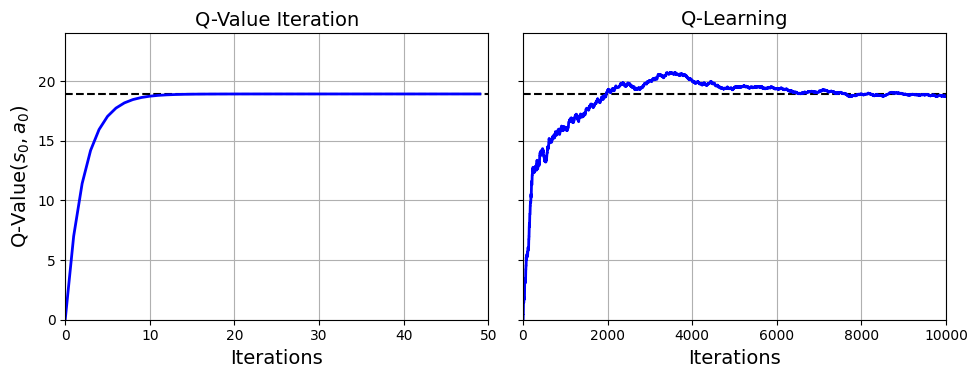

In [22]:
for iteration in range(10000):
    history2.append(Q_values.copy())
    action = exploration_policy(state)
    next_state, reward = step(state, action)
    next_value = Q_values[next_state].max()
    alpha = alpha0 / (1 + iteration * decay)
    Q_values[state, action] *= 1 - alpha
    Q_values[state, action] += alpha * (reward + gamma * next_value)
    state = next_state

history2 = np.array(history2)

true_Q_value = history1[-1, 0, 0]

# Configuration for the plot
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
axes[0].set_ylabel("Q-Value$(s_0, a_0)$", fontsize=14)
axes[0].set_title("Q-Value Iteration", fontsize=14)
axes[1].set_title("Q-Learning", fontsize=14)
for ax, width, history in zip(axes, (50, 10000), (history1, history2)):
    ax.plot([0, width], [true_Q_value, true_Q_value], "k--")
    ax.plot(np.arange(width), history[:, 0, 0], "b-", linewidth=2)
    ax.set_xlabel("Iterations", fontsize=14)
    ax.axis([0, width, 0, 24])
    ax.grid(True)

# Plot the results of the Q Learning algorithm and save the plot
save_fig("q_value_plot")
plt.show()

## Animate the Q Learning algorithm

In [44]:
# Code to animate the Q Learning algorithm
def qlearning_animation(state, epsilon = 0):
    if np.random.rand() < epsilon:
        return np.random.randint(env.action_space.n)  # random action
    else:
        Q_values = model.predict(state[np.newaxis], verbose=0)[0]
        return Q_values.argmax() # optimal action according to the Q-Values

np.random.seed(42)
show_one_episode(qlearning_animation)